#HOML Chapter 10 - Exercise 10

###Exercise: Train a deep MLP on the MNIST dataset (you can load it using keras.datasets.mnist.load_data(). See if you can get over 98% precision. Try searching for the optimal learning rate by using the approach presented in this chapter (i.e., by growing the learning rate exponentially, plotting the loss, and finding the point where the loss shoots up). Try adding all the bells and whistles—save checkpoints, use early stopping, and plot learning curves using TensorBoard.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

We'll set a couple of random seeds for consistency and reproducibility. 

In [ ]:
# Random seeds from both numpy and tensorflow
from numpy.random import seed
seed(999)
tf.random.set_seed(999)   

At times, we'll be mimicing the author's approach to the Fashion MNIST dataset, starting with loading the MNIST dataset and breaking it up into train (which will shortly be split into trianng and validation sets) and test sets.  

In [ ]:
(X_train_all, y_train_all), (X_test, y_test) = keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
X_train_all.shape

(60000, 28, 28)

In [ ]:
y_test.shape

(10000,)

As the author did with the Fashion MNIST dataset, we'll transform part of the training set in to the validation set. We want to allow a large enough number for validation, while also allowing for an adequate training set. At the same time, let's also convert the pixel values between 0 and 1 by dividing them by 255.

In [ ]:
(X_val, X_train) = X_train_all[5000:]/255., X_train_all[:5000]/255.  
(y_val, y_train) = y_train_all[5000:], y_train_all[:5000]
X_test = X_test/255. 

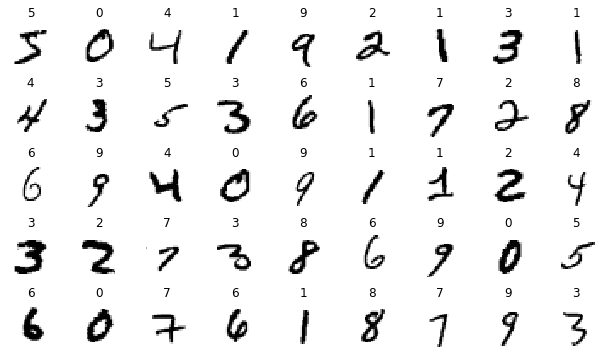

In [ ]:
# Display a sample of the training dataset

import matplotlib.pyplot as plt

n_rows = 5
n_cols = 9
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(y_train[index], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

Next, let's build a model with at least two hidden layers. Recall that the author mentioned that having too many layers and neurons may lead to overfitting. 

*Note: after running multiple trials with various number of layers and neurons, we settlesd upon the same basic model that the author used for the Fashion MNIST dataset. It performed no better or worse than any other combination we tried, but it gave us a means to compare to the author's code later in this notebook for this MNIST dataset. 

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(10, activation="softmax"))

In [ ]:
model.layers

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


As with the Fashion MNIST dataset, we'll complile our loss with sparse categorical crossentropy and use sgd for the optimizer. If we would hae one-hot encoded our data, categroical crossentropy would have been a better choice. 

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

In [ ]:
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_val, y_val))

Epoch 1/30
157/157 [==============================] - 4s 19ms/step - loss: 2.0153 - accuracy: 0.4172 - val_loss: 1.2457 - val_accuracy: 0.7570
Epoch 2/30
157/157 [==============================] - 3s 17ms/step - loss: 1.0444 - accuracy: 0.8019 - val_loss: 0.7458 - val_accuracy: 0.8292
Epoch 3/30
157/157 [==============================] - 3s 17ms/step - loss: 0.6549 - accuracy: 0.8528 - val_loss: 0.5699 - val_accuracy: 0.8596
Epoch 4/30
157/157 [==============================] - 3s 17ms/step - loss: 0.4976 - accuracy: 0.8783 - val_loss: 0.4849 - val_accuracy: 0.8724
Epoch 5/30
157/157 [==============================] - 3s 17ms/step - loss: 0.4149 - accuracy: 0.9008 - val_loss: 0.4474 - val_accuracy: 0.8764
Epoch 6/30
157/157 [==============================] - 3s 17ms/step - loss: 0.3892 - accuracy: 0.9064 - val_loss: 0.4144 - val_accuracy: 0.8846
Epoch 7/30
157/157 [==============================] - 3s 17ms/step - loss: 0.3284 - accuracy: 0.9203 - val_loss: 0.4027 - val_accuracy: 0.8855

We see training accuracy in the mid to high 90's while validation is in the low 90's, suggesting a bit of overfitting. 

We'll next graph our results.

In [ ]:
# Graphs of accuracy and loss
import matplotlib.pyplot as plt

def plot_graphs(history, string):
    plt.figure(figsize=(12, 5))
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.title('Training and validation')
    plt.xlabel('Epochs')
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

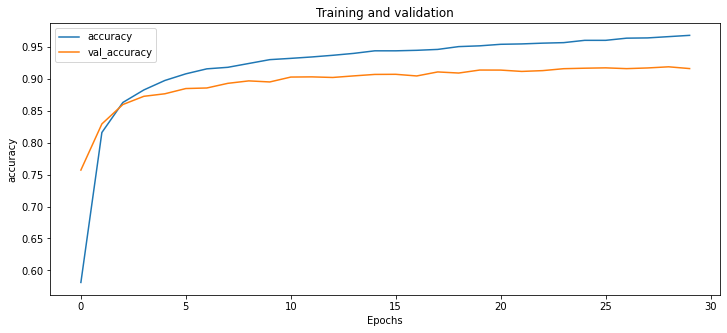

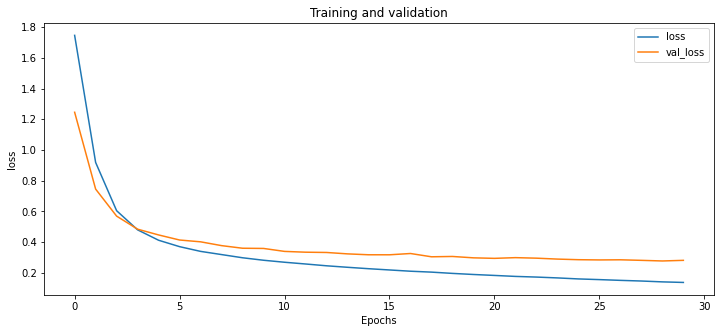

In [ ]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

The graph also shows some overfitting as the training loss improves at an increasingly faster pace than the validation loss. 

In [ ]:
# Evaluate on the test set
model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 2ms/step - loss: 0.2691 - accuracy: 0.9194


[0.2691424489021301, 0.9193999767303467]

Evaluating on our test set also results in low 90's accuracy.

Next, let's attempt to increase this accuracy. As a first step, the author recommends plotting the loss of an exponential learning rate. No instruction for how to construct this is given in the text,  so we'll use the author's code.

In [ ]:
# Expoential learning rate
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)

In [ ]:
# Clear session to free up additional memory
keras.backend.clear_session()
from numpy.random import seed
seed(999)
tf.random.set_seed(999)   

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(10, activation="softmax"))

Starting with a small learning rate, we'll increase it by 5.0% at each iteration.

In [ ]:
exlr = ExponentialLearningRate(factor=1.05)

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

We'll train for just one epoch to get a sense of where the loss dips before it spikes again.

In [ ]:
history = model.fit(X_train, y_train, epochs=1,
                    validation_data=(X_val, y_val),
                    callbacks=[exlr])

157/157 [==============================] - 3s 19ms/step - loss: 2662832360.5933 - accuracy: 0.3150 - val_loss: 1198777804531079707623424.0000 - val_accuracy: 0.0992


Text(0, 0.5, 'Loss')

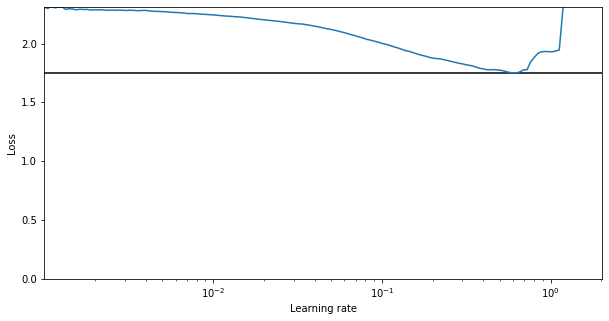

In [ ]:
# Plot loss against learning rate
plt.figure(figsize=(10,5))
plt.plot(exlr.rates, exlr.losses)
plt.gca().set_xscale('log')
plt.hlines(min(exlr.losses), min(exlr.rates), max(exlr.rates))
plt.axis([min(exlr.rates), max(exlr.rates), 0, exlr.losses[0]])
plt.xlabel("Learning rate")
plt.ylabel("Loss")


We see the loss shoot up around 6e-1. THe author mentions that we should use a learning rate half of the value where we see an increase, so we'll use 3e-1.

In [ ]:
keras.backend.clear_session()
from numpy.random import seed
seed(999)
tf.random.set_seed(999)   

Next, we'll use a couple of callbacks to potentially improve our results. This includes Tensorboard - the following two cells allow Tensorboard to work on Jupyter Notebook. They don't, however, appear to work with Colab.

In [ ]:
# Define root directory for Tensorboard logs
import os
root_logdir = os.path.join(os.curdir, "my_logs")

In [ ]:
# Function to create subdirectory path for current date and time 
def get_run_logdir():
 import time
 run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
 return os.path.join(root_logdir, run_id)
run_logdir = get_run_logdir()

In [ ]:
# An alternative way to create path for Tensorboard. Unfortunately, it causes issues with both 
# Jupyter Notbook and Colab
"""import os

run_index = 1 # increment this at every run
run_logdir = os.path.join(os.curdir, "mnist_logs", "run_{:03d}".format(run_index))
run_logdir"""

'./mnist_logs/run_001'

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(10, activation="softmax"))

In addition to Tensorboard, we'll also invoke EarlyStopping, which stops our training early if there is no loss improvement for a set number of epochs. We'll also use ModelCheckpoint, which saves the weights of the best performing epoch for use on the test set. 

In [ ]:
# Define callback list
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=15),
    tf.keras.callbacks.ModelCheckpoint(filepath='mnist.h5', save_best_only=True),
    tf.keras.callbacks.TensorBoard(run_logdir)
]

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=3e-1),
              metrics=["accuracy"])


In [ ]:
history = model.fit(X_train, y_train, epochs=30, 
                    validation_data=(X_val, y_val),
                    callbacks=my_callbacks, 
                    verbose=2)

Epoch 1/30
157/157 - 3s - loss: 0.6449 - accuracy: 0.7962 - val_loss: 0.3198 - val_accuracy: 0.9015
Epoch 2/30
157/157 - 3s - loss: 0.2076 - accuracy: 0.9376 - val_loss: 0.2445 - val_accuracy: 0.9245
Epoch 3/30
157/157 - 2s - loss: 0.1391 - accuracy: 0.9576 - val_loss: 0.2901 - val_accuracy: 0.9117
Epoch 4/30
157/157 - 2s - loss: 0.0892 - accuracy: 0.9722 - val_loss: 0.2160 - val_accuracy: 0.9359
Epoch 5/30
157/157 - 2s - loss: 0.0475 - accuracy: 0.9872 - val_loss: 0.2353 - val_accuracy: 0.9321
Epoch 6/30
157/157 - 2s - loss: 0.0302 - accuracy: 0.9926 - val_loss: 0.5890 - val_accuracy: 0.8624
Epoch 7/30
157/157 - 3s - loss: 0.0195 - accuracy: 0.9946 - val_loss: 0.2655 - val_accuracy: 0.9279
Epoch 8/30
157/157 - 2s - loss: 0.0096 - accuracy: 0.9986 - val_loss: 0.2188 - val_accuracy: 0.9442
Epoch 9/30
157/157 - 2s - loss: 0.0037 - accuracy: 0.9998 - val_loss: 0.2193 - val_accuracy: 0.9457
Epoch 10/30
157/157 - 2s - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.2229 - val_accuracy: 0.9463

In [ ]:
model = keras.models.load_model("mnist.h5") # rollback to best model
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.2036 - accuracy: 0.9366


[0.20358401536941528, 0.9366000294685364]

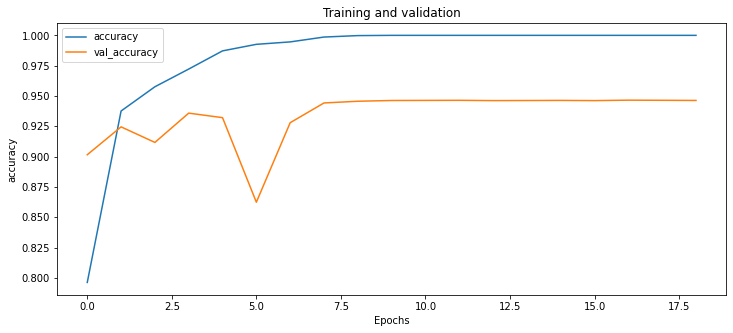

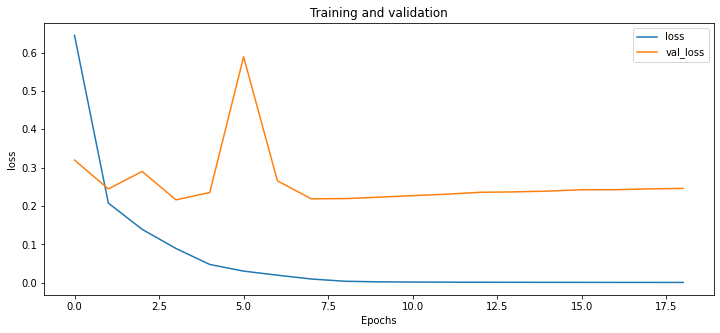

In [ ]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

While the training is a bit uneven, we do see a small improvement in our test accuracy, though we are still not close to achieving 98% accuracy.

If you wish to view similar graphs as above in Tensorboard, the following code should work in Jupyter Notebook/Lab.

In [ ]:
# Load the Tensorboard logs and view the epoch accuracy and loss. Again, this doesn't seem to work on Colab at the moment. 
%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=6006

Next, we'll do some hyperparameter tuning to improve our accuracy. A couple of useful sites in this regard are listed below. 

https://towardsdatascience.com/simple-guide-to-hyperparameter-tuning-in-neural-networks-3fe03dad8594
https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/


In [ ]:
keras.backend.clear_session()
from numpy.random import seed
seed(999)
tf.random.set_seed(999)   

In [ ]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

We need to first define a wrapper in scikit-learn that creates and returns our sequential model.

In [ ]:
def create_model():
  # define model
  model = keras.models.Sequential()
  model.add(keras.layers.Flatten(input_shape=[28, 28]))
  model.add(keras.layers.Dense(300, activation="relu"))
  model.add(keras.layers.Dense(100, activation='relu'))
  model.add(keras.layers.Dense(10, activation="softmax"))
    # compile model
  model.compile(loss='sparse_categorical_crossentropy',
              optimizer=keras.optimizers.SGD(lr=3e-1),
              metrics=['accuracy'])
  return model

Now, we need to provide a param_grid dictionary of the hyperparamters that we'll be tuning. In this case, we'll be tuning batch size and the number of epochs.

More useful info from Machine Learning Mastery: 

"By default, accuracy is the score that is optimized, but other scores can be specified in the score argument of the GridSearchCV constructor.

By default, the grid search will only use one thread. By setting the n_jobs argument in the GridSearchCV constructor to -1, the process will use all cores on your machine. Depending on your Keras backend, this may interfere with the main neural network training process.

The GridSearchCV process will then construct and evaluate one model for each combination of parameters. Cross validation is used to evaluate each individual model and the default of 3-fold cross validation is used, although this can be overridden by specifying the cv argument to the GridSearchCV constructor."

In [ ]:
%%time
seed = 999
np.random.seed(seed)

model_CV = KerasClassifier(build_fn=create_model, verbose=1)
# define the grid search parameters
batches = [32, 64]
epochs = [30, 60]

param_grid = dict(epochs=epochs, batch_size=batches)
grid = GridSearchCV(estimator=model_CV, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Epoch 1/60
157/157 [==============================] - 1s 2ms/step - loss: 1.0492 - accuracy: 0.6479
Epoch 2/60
157/157 [==============================] - 0s 2ms/step - loss: 0.2030 - accuracy: 0.9390
Epoch 3/60
157/157 [==============================] - 0s 2ms/step - loss: 0.1480 - accuracy: 0.9546
Epoch 4/60
157/157 [==============================] - 0s 2ms/step - loss: 0.0818 - accuracy: 0.9780
Epoch 5/60
157/157 [==============================] - 0s 2ms/step - loss: 0.0395 - accuracy: 0.9908
Epoch 6/60
157/157 [==============================] - 0s 2ms/step - loss: 0.0355 - accuracy: 0.9895
Epoch 7/60
157/157 [==============================] - 0s 2ms/step - loss: 0.0159 - accuracy: 0.9968
Epoch 8/60
157/157 [==============================] - 0s 2ms/step - loss: 0.0105 - accuracy: 0.9984
Epoch 9/60
157/157 [==============================] - 0s 2ms/step - loss: 0.0033 - accuracy: 0.9999
Epoch 10/60
157/157 [==============================] - 0s 2ms/step - loss: 0.0023 - accuracy: 0.9999

In [ ]:
# print results
print(f'Best Accuracy for {grid_result.best_score_:.4} using {grid_result.best_params_}')
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f'mean={mean:.4}, std={stdev:.4} using {param}')

Best Accuracy for 0.9436 using {'batch_size': 32, 'epochs': 60}
mean=0.942, std=0.01008 using {'batch_size': 32, 'epochs': 30}
mean=0.9436, std=0.008826 using {'batch_size': 32, 'epochs': 60}
mean=0.9382, std=0.01103 using {'batch_size': 64, 'epochs': 30}
mean=0.94, std=0.01442 using {'batch_size': 64, 'epochs': 60}


We find that using batch size of 32 and 60 epochs provides us with the highest accuracy. Let's now implement this with our model.

In [ ]:
keras.backend.clear_session()
from numpy.random import seed
seed(999)
tf.random.set_seed(999)   

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(10, activation="softmax"))

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(3e-1),
              metrics=["accuracy"])

In [ ]:
history = model.fit(X_train, y_train, epochs=60, batch_size=32, 
                    validation_data=(X_val, y_val),
                    callbacks=my_callbacks, 
                    verbose=2)

Epoch 1/60
157/157 - 3s - loss: 0.6446 - accuracy: 0.7960 - val_loss: 0.3156 - val_accuracy: 0.9031
Epoch 2/60
157/157 - 2s - loss: 0.2082 - accuracy: 0.9378 - val_loss: 0.2456 - val_accuracy: 0.9230
Epoch 3/60
157/157 - 2s - loss: 0.1411 - accuracy: 0.9578 - val_loss: 0.2987 - val_accuracy: 0.9087
Epoch 4/60
157/157 - 2s - loss: 0.0853 - accuracy: 0.9728 - val_loss: 0.2216 - val_accuracy: 0.9345
Epoch 5/60
157/157 - 2s - loss: 0.0452 - accuracy: 0.9880 - val_loss: 0.2355 - val_accuracy: 0.9309
Epoch 6/60
157/157 - 2s - loss: 0.0307 - accuracy: 0.9914 - val_loss: 0.2549 - val_accuracy: 0.9300
Epoch 7/60
157/157 - 2s - loss: 0.0149 - accuracy: 0.9968 - val_loss: 0.2252 - val_accuracy: 0.9403
Epoch 8/60
157/157 - 2s - loss: 0.0077 - accuracy: 0.9988 - val_loss: 0.2181 - val_accuracy: 0.9445
Epoch 9/60
157/157 - 2s - loss: 0.0035 - accuracy: 0.9998 - val_loss: 0.2205 - val_accuracy: 0.9455
Epoch 10/60
157/157 - 2s - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.2232 - val_accuracy: 0.9460

In [ ]:
model = keras.models.load_model("mnist.h5") # rollback to best model
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.2020 - accuracy: 0.9463


[0.20200681686401367, 0.9463000297546387]

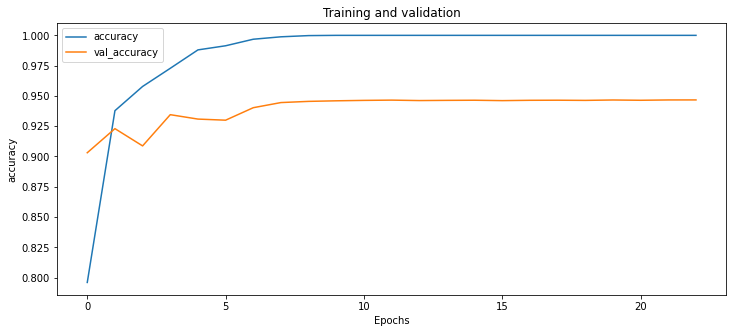

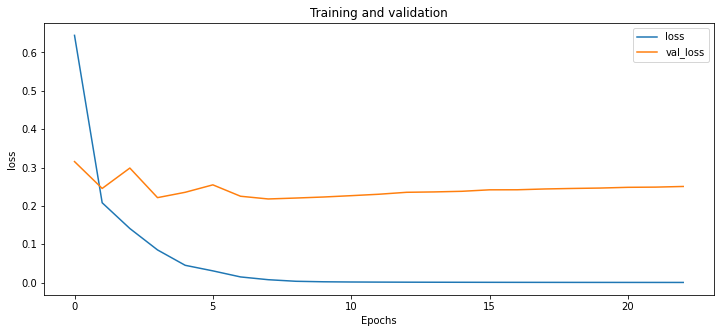

In [ ]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

The tuning made a small difference to our accuracy but didn't allow us to  achieve 98% accuracy, likely because a batch size of 32 is already used by default. With additional time, it would be useful to also test the ideal number of neurons in our first hidden layer or even add a dropout layer and test its ideal rate.

*Note: we did test dropout layers (without tuning) several times, but they either made an insignificant improvment in test accuracy or gave abysmally low test accuracy.

Finally, let's test the author's own code. 

In [ ]:
keras.backend.clear_session()
from numpy.random import seed
seed(42)
tf.random.set_seed(42)  

In [ ]:

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [ ]:

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=3e-1),
              metrics=["accuracy"])

In [ ]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
checkpoint_cb = keras.callbacks.ModelCheckpoint("mnist.h5", save_best_only=True)
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])

Epoch 1/100
157/157 [==============================] - 5s 29ms/step - loss: 1.0534 - accuracy: 0.6511 - val_loss: 0.5843 - val_accuracy: 0.8182
Epoch 2/100
157/157 [==============================] - 4s 26ms/step - loss: 0.2396 - accuracy: 0.9292 - val_loss: 0.2702 - val_accuracy: 0.9165
Epoch 3/100
157/157 [==============================] - 4s 26ms/step - loss: 0.1517 - accuracy: 0.9529 - val_loss: 0.2454 - val_accuracy: 0.9256
Epoch 4/100
157/157 [==============================] - 4s 27ms/step - loss: 0.0759 - accuracy: 0.9762 - val_loss: 0.2685 - val_accuracy: 0.9221
Epoch 5/100
157/157 [==============================] - 4s 27ms/step - loss: 0.0442 - accuracy: 0.9879 - val_loss: 0.2258 - val_accuracy: 0.9355
Epoch 6/100
157/157 [==============================] - 4s 27ms/step - loss: 0.0311 - accuracy: 0.9909 - val_loss: 0.2885 - val_accuracy: 0.9227
Epoch 7/100
157/157 [==============================] - 4s 26ms/step - loss: 0.0281 - accuracy: 0.9919 - val_loss: 0.2243 - val_accuracy:

In [ ]:
model = keras.models.load_model("mnist.h5") # rollback to best model
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.1985 - accuracy: 0.9507


[0.1985192447900772, 0.9506999850273132]

Despite using the same code (and seeding) that the author used, we still are not able to achieve 98% test accuracy, though he managed to do so in his own notebook. In fact, our code is almost identical to the author's (including learning rate), except for the random seeding values. 

So it seems safe to assume that both models should be equally effective and only appear not to be so due to the seeding values. 